In [3]:
from commons import *

In [4]:
algorithmshortcuts = {
    'bestfirst_cfssubseteval': 'se-bf',
    'greedystepwise_cfssubseteval': "se-gs",
    'ranker_correlationattributeeval': "cr",
    'ranker_gainratioattributeeval': "gr",
    'ranker_infogainattributeeval': "ig",
    'ranker_onerattributeeval': "or",
    'ranker_principalcomponents': "pca",
    'ranker_relieffattributeeval': 're',
    'ranker_symmetricaluncertattributeeval': 'su',
    'bayesnet': 'bn',
    'decisionstump': "ds",
    'decisiontable': "dt",
    'ibk': "ibk",
    'j48': "j48",
    'jrip': "jrip",
    'kstar': "k*",
    'lmt': "lmt",
    'logistic': "lr",
    'multilayerperceptron': "ann",
    'naivebayes': "nb",
    'naivebayesmultinomial': "nbm",
    'oner': "1-r",
    'part': "part",
    'randomforest': "rf",
    'randomtree': "rt",
    'reptree': "rep",
    'simplelogistic': "sl",
    'sl': "sl2",
    'smo': "smo",
    'votedperceptron': "vp",
    'zeror': "0-r"
}

featureAliases = {
    'fitsize': "ni",
    'numattributes': "na",
    'numlabels': "nl",
    'numnumericattributes': "nn",
    'numsymbolicattributes': "ns",
    'numberofcategories': "nc",
    'numericattributesafterbinarization': "nab",
    'totalvariance': "tv",
    'attributestocover50pctvariance': "v50",
    'attributestocover90pctvariance': "v90",
    'attributestocover95pctvariance': "v95",
    'attributestocover99pctvariance': "v99"
}
learnerAliases = {
    'ann': 'ANN',
    'forest': 'RF',
    'linear': 'LR'
}

In [5]:
df = pd.read_csv("data/metafeaturetransformations.csv")
df

,openmlid,algorithm,algorithmoptions,numinstances_before,numattributes_before,numlabels_before,numnumericattributes_before,numsymbolicattributes_before,numberofcategories_before,numericattributesafterbinarization_before,...,numlabels_after,numnumericattributes_after,numsymbolicattributes_after,numberofcategories_after,numericattributesafterbinarization_after,attributestocover50pctvariance_after,attributestocover90pctvariance_after,attributestocover95pctvariance_after,attributestocover99pctvariance_after,totalvariance_after
0,3,bestfirst_cfssubseteval,-D 0 -N 1 -S 0;-L,10.0,36.0,2.0,0.0,36.0,74.0,40.0,...,2.0,0.0,2.0,4.0,2.0,4.0,8.0,9.0,9.0,1.477778
1,3,bestfirst_cfssubseteval,-D 0 -N 1 -S 0;-L,10.0,36.0,2.0,0.0,36.0,74.0,40.0,...,2.0,0.0,2.0,4.0,2.0,4.0,8.0,9.0,9.0,1.477778
2,3,bestfirst_cfssubseteval,-D 0 -N 1 -S 0;-M -L,10.0,36.0,2.0,0.0,36.0,74.0,40.0,...,2.0,0.0,2.0,4.0,2.0,4.0,8.0,9.0,9.0,1.477778
3,3,bestfirst_cfssubseteval,-D 0 -N 1 -S 1;-L,10.0,36.0,2.0,0.0,36.0,74.0,40.0,...,2.0,0.0,2.0,4.0,2.0,4.0,8.0,9.0,9.0,1.477778
4,3,bestfirst_cfssubseteval,-D 1 -N 1 -S 0;-L,10.0,36.0,2.0,0.0,36.0,74.0,40.0,...,2.0,0.0,2.0,4.0,2.0,4.0,8.0,9.0,9.0,1.477778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618940,40971,ranker_symmetricaluncertattributeeval,-N 1000;,1000.0,23.0,30.0,20.0,3.0,1017.0,1036.0,...,30.0,20.0,3.0,1017.0,1036.0,1.0,1.0,1.0,1.0,83465.798050
1618941,40971,ranker_symmetricaluncertattributeeval,-N 100;-M,1000.0,23.0,30.0,20.0,3.0,1017.0,1036.0,...,30.0,20.0,3.0,1017.0,1036.0,1.0,1.0,1.0,1.0,83465.798050
1618942,40971,ranker_symmetricaluncertattributeeval,-N 1000;-M,100.0,23.0,29.0,20.0,3.0,1017.0,1036.0,...,29.0,20.0,3.0,1017.0,1036.0,1.0,1.0,1.0,1.0,84931.181166
1618943,40971,ranker_symmetricaluncertattributeeval,-N 1000;-M,1000.0,23.0,30.0,20.0,3.0,1017.0,1036.0,...,30.0,20.0,3.0,1017.0,1036.0,1.0,1.0,1.0,1.0,83465.798050


In [6]:
metafeatures = ["numattributes", "numlabels", "numnumericattributes", "numsymbolicattributes", "numberofcategories", "numericattributesafterbinarization", "attributestocover50pctvariance", "attributestocover90pctvariance", "attributestocover95pctvariance", "attributestocover99pctvariance"]
inputfeaturesDataset = [x + "_before" for x in metafeatures]
targets = [x + "_after" for x in metafeatures]

fileResultsSample = "data/workdata/metafeaturepredictionresults-selection.csv"
fileResultsFinal = "data/workdata/metafeaturepredictionresults-final.csv"

In [79]:
for algo in algorithms:
    print(algo)
    print(explodeAlgorithmOptions(df.query("algorithm == '" + algo + "'"))[["N", "numattributes_before", "numattributes_after"]].query("N <= numattributes_before and N != numattributes_after"))

bestfirst_cfssubseteval
           N  numattributes_before  numattributes_after
0        1.0                  36.0                  2.0
1        1.0                  36.0                  2.0
2        1.0                  36.0                  2.0
3        1.0                  36.0                  2.0
4        1.0                  36.0                  2.0
...      ...                   ...                  ...
1028949  1.0                8460.0                 16.0
1028950  2.0                8460.0                 16.0
1028951  1.0                8460.0                 10.0
1028952  1.0                8460.0                 16.0
1040195  1.0               11465.0                  9.0

[180597 rows x 3 columns]
greedystepwise_cfssubseteval
           N  numattributes_before  numattributes_after
8639     1.0                  36.0                  2.0
8640     1.0                  36.0                  2.0
8641     1.0                  36.0                  2.0
8643     1.0            

In [7]:
datasets = pd.unique(df["openmlid"])
algorithms = pd.unique(df["algorithm"])

In [8]:
def overMAPE(A, F):
    n = 0
    s = 0
    for i in range(len(A)):
        if A[i] <= F[i]:
            s += (F[i] - A[i]) / A[i]
            n+=1
    if n == 0:
        return 0
    return s / n

def underMAPE(A, F):
    n = 0
    s = 0
    for i in range(len(A)):
        if A[i] >= F[i]:
            s += (A[i] - F[i]) / F[i]
            n+=1
    if n == 0:
        return 0
    return s / n

## 1. For each pre-processor, which Subsets of size at most 3 can best predict the number of attributes?

### Compute the error of a linear regression of each feature set, each pre-processor, and each sample ds

In [9]:
def getPredictionError(trainDF, validationDF, features, target):
    Xtrain = trainDF[features]
    Ytrain = trainDF[t]
    if "minAttN" in features:
        print(pd.concat([Xtrain, Ytrain], axis=1).query("minAttN != numattributes_after"))
    
    reg = sk.linear_model.LinearRegression()#n_estimators=100)
    reg.fit(Xtrain, Ytrain)
    actuals = validationDF[t].values
    predictions = np.maximum(1, np.round(reg.predict(validationDF[features])))
    if len(predictions) != len(actuals):
        raise Exception()
    #print("\t\tGT: " + str(validationDF[t].values))
    #print("\t\tBF: " + str(validationDF["numattributes_before"].values))
    #print("\t\tPR: " + str(predictions))
    error = np.sqrt(sk.metrics.mean_squared_error(actuals, predictions))
    e1 = np.round(overMAPE(actuals, predictions), 2) if np.count_nonzero(actuals >= predictions) > 0 else 0
    e2 = np.round(underMAPE(actuals, predictions), 2) if np.count_nonzero(actuals <= predictions) > 0 else 0
    return error, e1, e2

def getAllFeatureSetsOfSizeK(features, minK, maxK):
    F = []
    for k in range(minK,maxK + 1):
        F.extend([list(x) for x in itertools.combinations(features, k)])
    return F

In [10]:
def gatherPredictionResults(df, featurecombos, fileResults):
    cols = ["featureset", "algorithm", "openmlid", "RMSE"]
    dfResults = pd.DataFrame([], cols)

    pbar = tqdm(total = len(algorithms) * len(selectedDatasets) * len(featurecombos))
    dfResults = pd.read_csv(fileResults, delimiter=";") if path.exists(fileResults) else pd.DataFrame([], columns=cols)
    i = 0
    for features in featurecombos:
        t = "numattributes_after"
        dfMatch1 = dfResults[(dfResults["featureset"] == str(features))]
        for a in algorithms:
            dfMatch2 = dfMatch1[(dfMatch1["algorithm"] == a)]
            dfAlgo = explodeAlgorithmOptions(df[df["algorithm"] == a])
            algoParams = [x for x in dfAlgo.columns if not x in df.columns]
            algoParams.remove("searcheroptions")
            algoParams.remove("evaloptions")
            algoSpecificFeatures = features.copy()
            algoSpecificFeatures.extend(algoParams)
            print(algoSpecificFeatures)
            if "ranker" in a or "greedy" in a:
                dfAlgo["minAttN"] = np.minimum(dfAlgo["numattributes_before"], dfAlgo["N"])
                algoSpecificFeatures.append("minAttN")

            if "principal" in a:
                dfAlgo["minAttA"] = np.minimum(dfAlgo["minAttN"], dfAlgo["A"])
                algoSpecificFeatures.append("minAttA")

            for d in selectedDatasets:
                match = dfMatch2[dfMatch2["openmlid"] == d]
                if len(match) == 0:
                    trainIndices = dfAlgo["openmlid"] != d
                    trainDF = dfAlgo[trainIndices]
                    validationDF = dfAlgo[~trainIndices]
                    if len(validationDF) > 0:
                        print(a)
                        rmse, e2, e3 = getPredictionError(trainDF, validationDF, algoSpecificFeatures, t)
                        print(rmse)
                        dfResults.loc[len(dfResults)] = [str(features), a, d, rmse]
                        i += 1
                        if i % 500 == 0:
                            dfResults.to_csv(fileResults, index=False, sep=";")
                            i = 0
                pbar.update(1)
    if i > 0:
        dfResults.to_csv(fileResults, index=False, sep=";")
    pbar.close()

In [11]:
selectedDatasets = [3, 38, 357, 723, 807, 897, 971, 1039, 1138, 23380, 41991] # see 2nd notebook
dfSample = df[df["openmlid"].isin(selectedDatasets)]

In [118]:
combos = getAllFeatureSetsOfSizeK(inputfeaturesDataset, 1, 3)
combos.append(inputfeaturesDataset) # also consider the complete set
gatherPredictionResults(dfSample, combos, fileResultsSample)

['numattributes_before', 'D', 'N', 'S', 'L', 'M', 'Z']
['numattributes_before', 'C', 'B', 'N', 'L', 'M', 'Z']
['numattributes_before', 'N']
['numattributes_before', 'N']
['numattributes_before', 'N', 'M', 'B']
['numattributes_before', 'N', 'D', 'F', 'B']
['numattributes_before', 'N', 'A', 'R', 'C', 'O']
['numattributes_before', 'N', 'K', 'M', 'A', 'W']
['numattributes_before', 'N', 'M']
['numlabels_before', 'D', 'N', 'S', 'L', 'M', 'Z']
['numlabels_before', 'C', 'B', 'N', 'L', 'M', 'Z']
['numlabels_before', 'N']
['numlabels_before', 'N']
['numlabels_before', 'N', 'M', 'B']
['numlabels_before', 'N', 'D', 'F', 'B']
['numlabels_before', 'N', 'A', 'R', 'C', 'O']


KeyboardInterrupt: 

### Create a box plot series of the 20 best sets with one box plot per feature set over the observed rmses

In [12]:
dfResultsSample = pd.read_csv(fileResultsSample, delimiter=";")

Best feature set: ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before']
Performance of this set: 2.064231066349641
Performance of simple set: 2.224748583018005


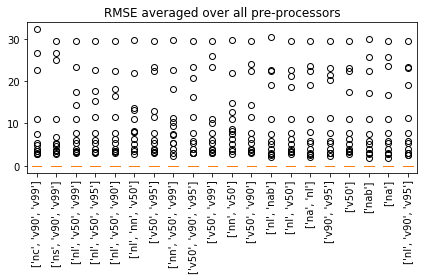

In [13]:
fsets = []
groups = []
scores = []
for gIndex, group in dfResultsSample.groupby("featureset"):
    rmse = np.mean(group["RMSE"])
    groups.append(group["RMSE"].values)
    fsets.append(gIndex)
    scores.append(rmse)
indices = np.argsort(scores)[0:20]

print("Best feature set: " + str(ast.literal_eval(fsets[indices[0]])))
print("Performance of this set: " + str(scores[indices[0]]))
print("Performance of simple set: " + str(scores[fsets.index("['numattributes_before']")]))

fig = plt.figure()
plt.boxplot([groups[i] for i in indices])
ax = fig.axes[0]
ax.set_title("RMSE averaged over all pre-processors")
ax.set_xticklabels([str([featureAliases[a.replace("_before", "")] for a in ast.literal_eval(fsets[i])]) for i in indices], rotation=90)
plt.tight_layout()
plt.savefig("plots/metafeatures-featuresets.pdf")
plt.show()

### Create also one series per algorithm to see whether there are local differences

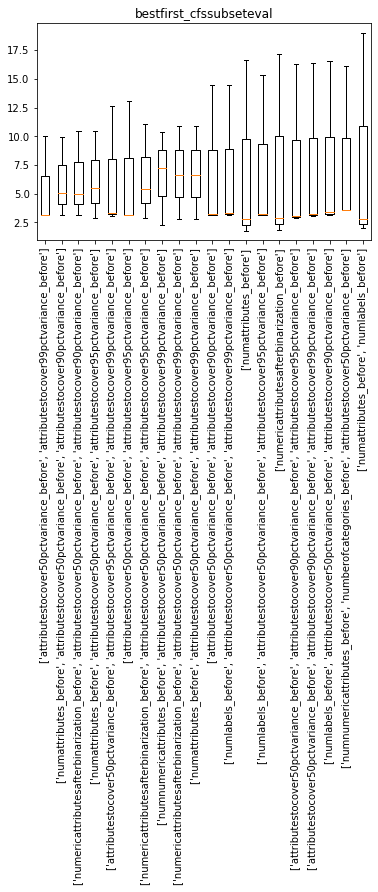

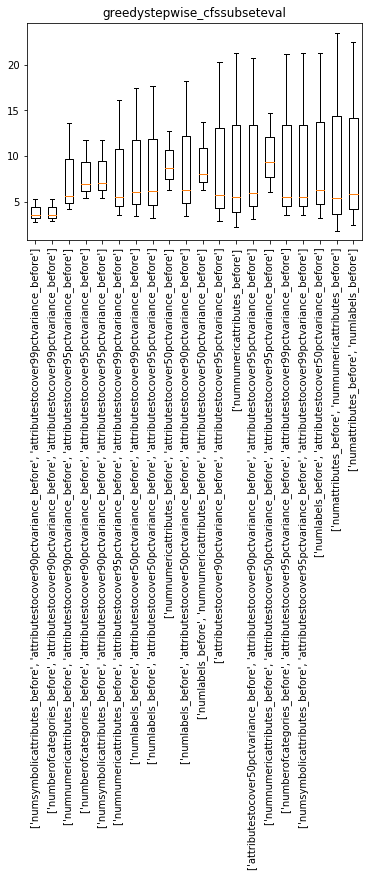

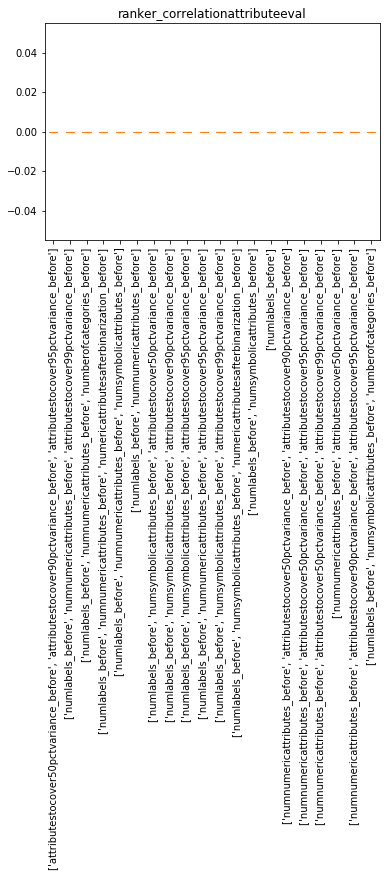

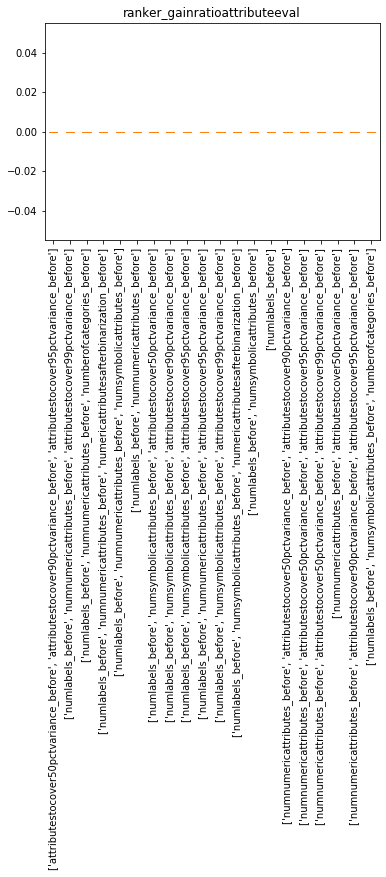

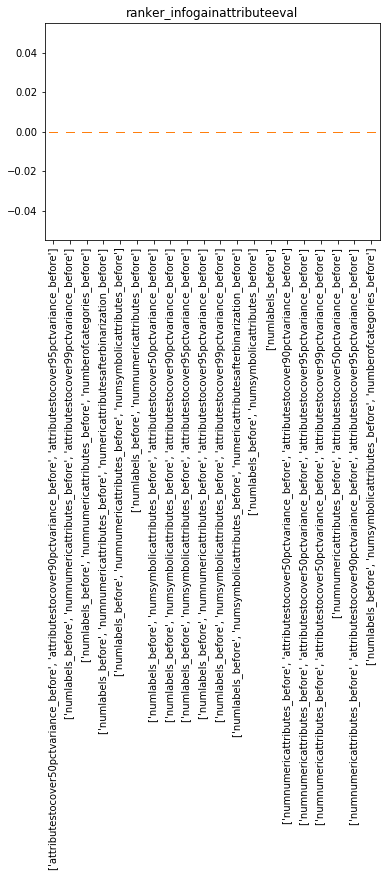

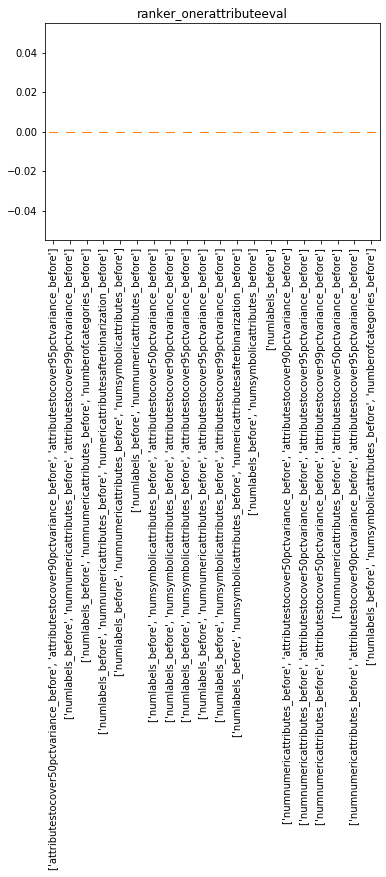

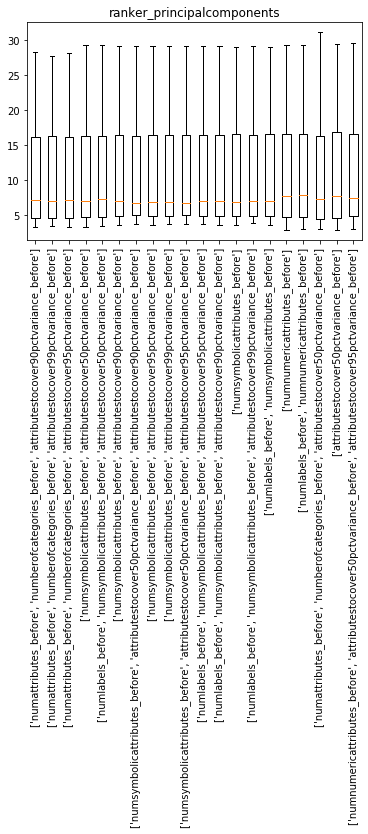

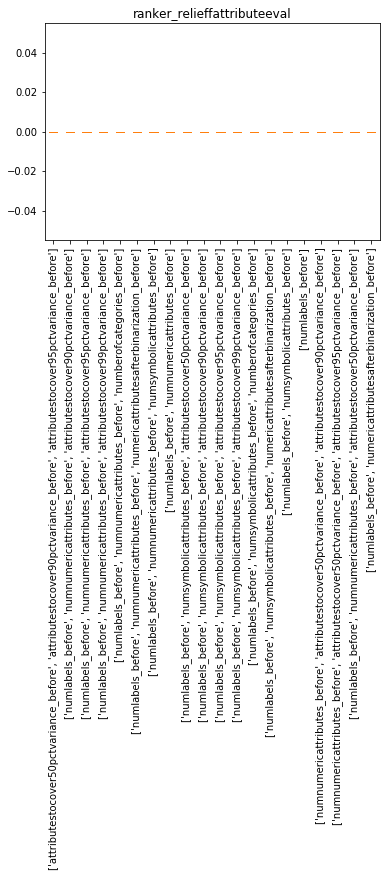

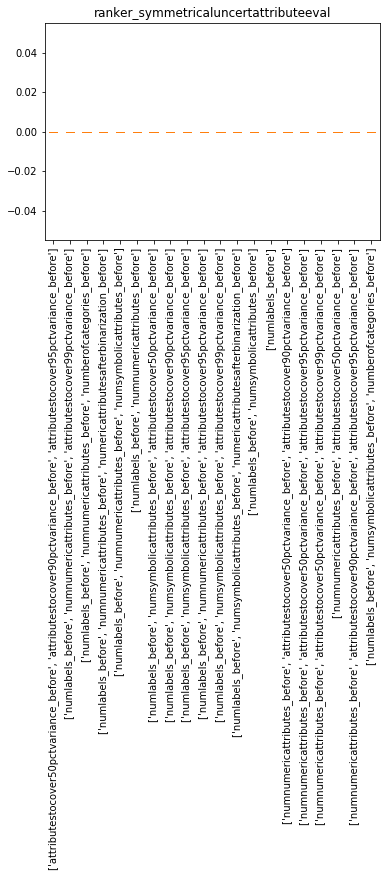

In [14]:
for algo in algorithms:
    fsets = []
    groups = []
    scores = []
    for gIndex, group in dfResultsSample.query("algorithm == '" + algo + "'").groupby("featureset"):
        rmse = np.mean(group["RMSE"])
        groups.append(group["RMSE"].values)
        fsets.append(gIndex)
        scores.append(rmse)
    indices = np.argsort(scores)[0:20]

    fig = plt.figure()
    plt.boxplot([groups[i] for i in indices])
    ax = fig.axes[0]
    ax.set_title(algo)
    ax.set_xticklabels([str(fsets[i]) for i in indices], rotation=90)
    plt.show()
    

**Observation**: Indeed, greedystepwise seems to be sensitive to the feature set.

# 2. What is the RMSE/relative error per learner overall for this FS?

## Gather results for this question

In [15]:
combosFinal = [['numattributes_before'], ['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before']]
gatherPredictionResults(df, combosFinal, fileResultsFinal)

['numattributes_before', 'D', 'N', 'S', 'L', 'M', 'Z']
['numattributes_before', 'C', 'B', 'N', 'L', 'M', 'Z']
['numattributes_before', 'N']
['numattributes_before', 'N']
['numattributes_before', 'N', 'M', 'B']
['numattributes_before', 'N', 'D', 'F', 'B']
['numattributes_before', 'N', 'A', 'R', 'C', 'O']
['numattributes_before', 'N', 'K', 'M', 'A', 'W']
['numattributes_before', 'N', 'M']
['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'D', 'N', 'S', 'L', 'M', 'Z']
['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'C', 'B', 'N', 'L', 'M', 'Z']
['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'N']
['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99pctvariance_before', 'N']
['numberofcategories_before', 'attributestocover90pctvariance_before', 'attributestocover99p

### Plot lof-RMSE for each learner using for the best case and for numattributes_before over all datasets

In [16]:
dfResultsFinal = pd.read_csv(fileResultsFinal, delimiter=";")

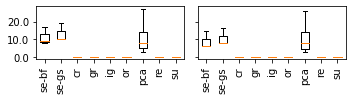

In [20]:
xlabels = [algorithmshortcuts[a] for a in algorithms]
ylabels = np.linspace(0, 40, 5)
fig, ax = plt.subplots(1, 2, figsize=(5, 1.5), sharey = True)
a = ax[0]
a.boxplot([dfResultsFinal.query("featureset == \"" + str(combosFinal[0]) + "\" and algorithm == '" + a + "'")["RMSE"].values for a in algorithms])
a.set_xticklabels(xlabels, rotation=90)
a.set_yticks(np.array(ylabels))
a.set_yticklabels(ylabels)
a = ax[1]
a.boxplot([dfResultsFinal.query("featureset == \"" + str(combosFinal[1]) + "\" and algorithm == '" + a + "'")["RMSE"].values for a in algorithms])
a.set_xticklabels(xlabels, rotation=90)
fig.tight_layout()
fig.savefig("plots/metafeaturepredictability.pdf")
pass

### Create one file per pre-processor

In [145]:
cols = list(df.columns)
for algo in tqdm(algorithms):
    dfAlgo = explodeAlgorithmOptions(df[df["algorithm"] == algo])
    algoSpecificCols = [x for x in dfAlgo.columns if not x in cols]
    algoSpecificCols.remove("searcheroptions")
    algoSpecificCols.remove("evaloptions")
    colsHere = ["openmlid", "algorithm", "numattributes_before"]
    colsHere.extend(algoSpecificCols)
    if "ranker" in algo or "greedy" in algo:
        dfAlgo["minAttN"] = np.minimum(dfAlgo["numattributes_before"], dfAlgo["N"])
        colsHere.append("minAttN")

    if "principal" in algo:
        dfAlgo["minAttA"] = np.minimum(dfAlgo["minAttN"], dfAlgo["A"])
        colsHere.append("minAttA")
    colsHere.append("numattributes_after")
    dfAlgo[colsHere].to_csv("data/metamodeldata/" + algo + ".csv", index=False)